# Końcowy model i ewaluacja
## Topic: School grades - Predict grades of school students based on lifestyle attributes


Adrianna Grudzień,\
Kinga Ułasik

# Importowanie potrzebnych pakietów

In [ ]:
import pandas as pd
import pylab as pl
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

# Wczytanie danych

In [ ]:
#grades_final - plik .csv wygenerowany w poprzednim etapie projektu po mapowaniu i kodowaniu zmiennych
grades_org = pd.read_csv('grades_final.csv')
grades_org.head()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,other,reputation,guardian_mother,guardian_other
0,0,1,1,18,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1,1,1,17,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2,1,1,15,1,1,1,1,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12,0,0,0,0,0,1,0,0,0,1,0,1,0
3,3,1,1,15,1,0,1,4,2,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14,1,0,0,0,0,0,1,0,1,0,0,1,0
4,4,1,1,16,1,0,1,3,3,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13,0,1,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
#wiek normalizujemy logarytmicznie - dzięki temu błąd jest jeszcze mniejszy
grades = grades_org.copy(deep=True)
grades['age'] = np.log2(grades['age']) 
grades.head()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,other,reputation,guardian_mother,guardian_other
0,0,1,1,4.169925,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1,1,1,4.087463,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2,1,1,3.906891,1,1,1,1,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12,0,0,0,0,0,1,0,0,0,1,0,1,0
3,3,1,1,3.906891,1,0,1,4,2,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14,1,0,0,0,0,0,1,0,1,0,0,1,0
4,4,1,1,4.000000,1,0,1,3,3,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13,0,1,0,0,0,1,0,0,1,0,0,0,0


# Prezentowanie finalnego modelu
Najlepszy model byliśmy w stanie uzyskać wybierając jako parametry zmienne:
* G2 -  2nd period grade
* failures - failures - number of past class failures 
* higher - wants to take higher education (binary: 1 or 0)
* studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
* school - student's school (binary: 1 - Gabriel Pereira or 0 - Mousinho da Silveira)
* age - student's age (numeric: from 15 to 22) [normalized]
* goout -  going out with friends (numeric: from 1 - very low to 5 - very high)
* freetime -  free time after school (numeric: from 1 - very low to 5 - very high)
* Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)


In [ ]:
X = grades[['G2','failures', 'higher', 'studytime', 'school', 'age', 'goout', 'freetime', 'Dalc']]
Y = grades['G3']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', error)
test_set_r2 = r2_score(y_test, y_pred)
print('R-squared:', test_set_r2)

Root Mean Squared Error: 0.9809479465281395
R-squared: 0.8645450875659495


# Strojenie hiperparametrów

In [ ]:
#sprawdźmy jakie parametry ma Linear Regression
regressor.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

Opis hiperparametrów:
* fit_intercept - whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations (i.e. data is expected to be centered)
* normalize - if True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm
* n_jobs - the number of jobs to use for the computation. This will only provide speedup for n_targets > 1 and sufficient large problems. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors




In [ ]:
#strojenie hiperparametrów

from numpy import arange
grid_values = {'fit_intercept':['True', 'False'],  
    'normalize':['True', 'False'],
    #'n_jobs': arange(-1, 10, 1)}
    'n_jobs' :[-1, 'None', 1]}
grid_regressor_acc = GridSearchCV(regressor, param_grid = grid_values, scoring = 'neg_mean_squared_error')
grid_regressor_acc.fit(X_train, y_train)

y_pred_acc = grid_regressor_acc.predict(X_test)
# New Model Evaluation metrics 
print(grid_regressor_acc.best_params_)
print('RMSE : ' + str(mean_squared_error(y_test,y_pred_acc)))
print('R2 squared : ' + str(r2_score(y_test,y_pred_acc)))


{'fit_intercept': 'True', 'n_jobs': -1, 'normalize': 'True'}
RMSE : 0.9622588737977708
R2 squared : 0.8645450875659498


In [ ]:
#model z hiperparametrami
regressor = LinearRegression(fit_intercept='True', n_jobs = -1, normalize=True)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print('RMSE : ' + str(mean_squared_error(y_test,y_pred)))
print('R2 squared : ' + str(r2_score(y_test,y_pred)))

RMSE : 0.9622588737977708
R2 squared : 0.8645450875659498


Otrzymaliśmy lekko lepsze wyniki niż przed strojeniem.

# Kroswalidacja
Żeby sprawdzić jak wypada model, została przeprowadzona kroswalidacja. Jako narzędzia ewaluacyjne zostały użyte dwie miary:
* RMSE - pierwiastek kwadratowy średniej kwadratów różnic między prognozą a rzeczywistą obserwacją
* R2 - jedna z miar jakości dopasowania modelu do danych uczących,  gdy R2 = 1 wówczas model jest idealny

In [ ]:
from sklearn.model_selection import cross_validate
print((-1)*np.mean(cross_validate(regressor, X_test, y_test, cv=20, scoring='neg_root_mean_squared_error').get('test_score')))
print(np.mean(cross_validate(regressor, X_test, y_test, cv=20, scoring='r2').get('test_score')))

0.9135234415045297
0.7884095196388904


# Zależności między parametrami a zmienną targetową
Przyjrzyjmy się bliżej relacji pomiędzy parametrami a zmienną targetową. Na początku zostanie przedstawiona tablica współczynników stojących przy wartościach zmiennych, a następnie - wizualicje krzywych najlepszego dopasowania.

In [ ]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)

           Coefficient
G2            0.995922
failures     -0.254465
higher        0.096815
studytime     0.074919
school        0.248308
age           0.242837
goout        -0.003889
freetime     -0.041020
Dalc         -0.095967


Możemy zauwazyć, że współczynniki stojące przy goout i freetime są bardzo małe, więc jeśli zaszłaby taka potrzeba, można by zbudować model działający podobnie dobrze bez tych dwóch zmiennych.

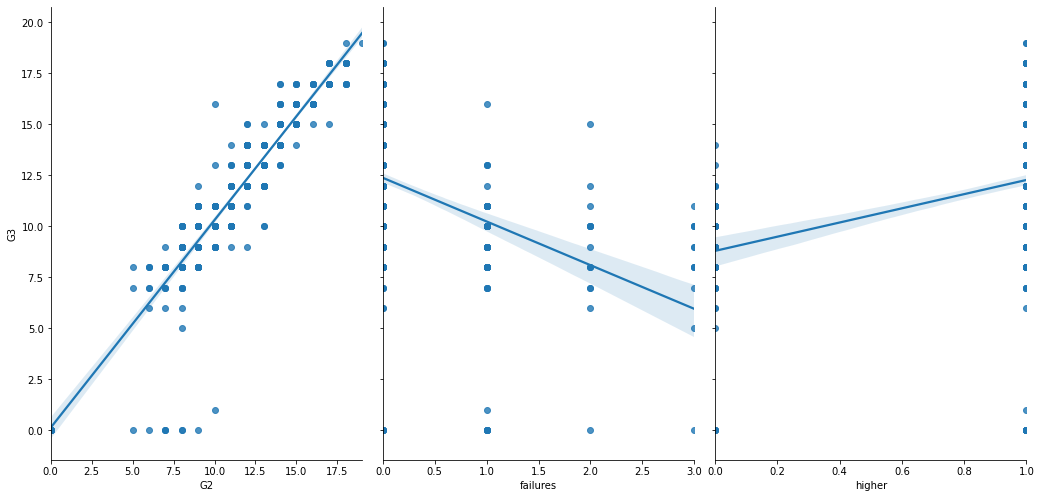

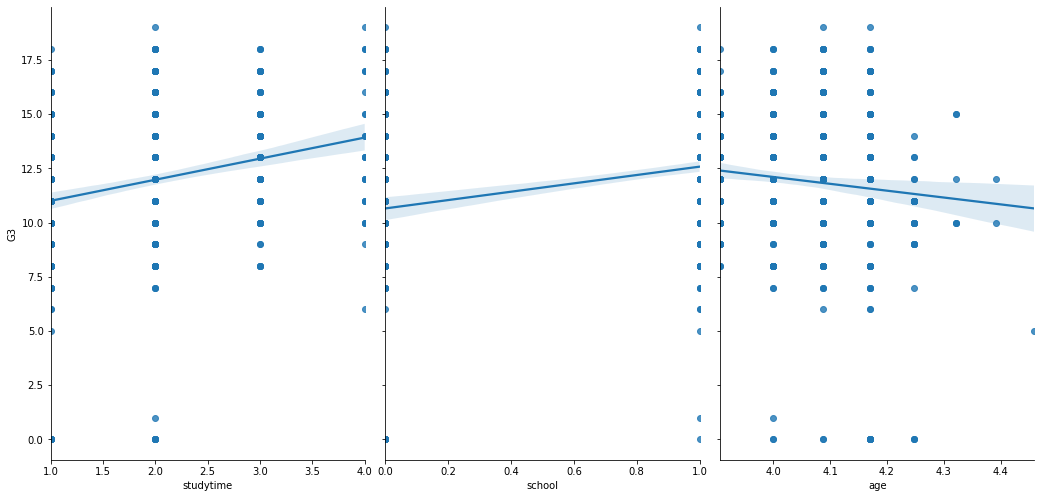

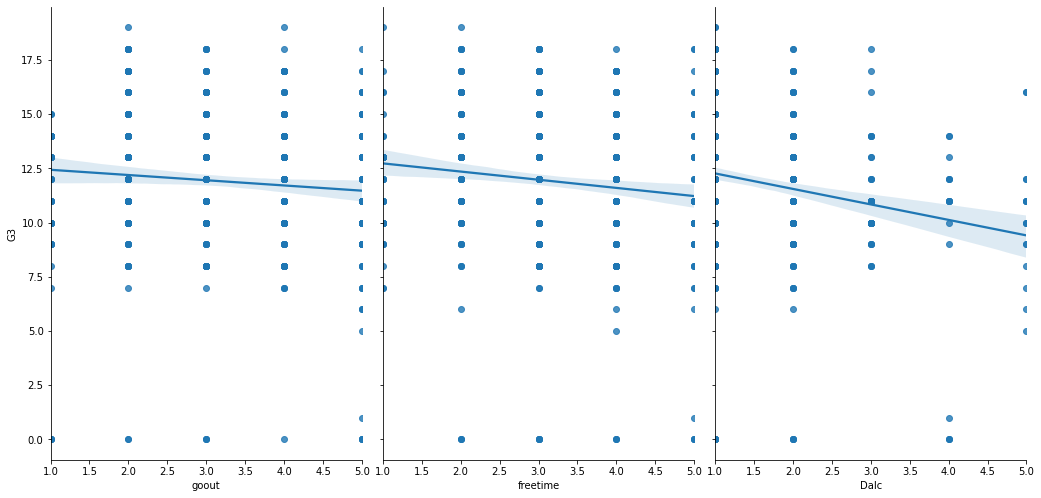

In [ ]:
sns.pairplot(grades, x_vars= ['G2', 'failures', 'higher'], y_vars='G3', size=7, aspect=0.7, kind='reg')
sns.pairplot(grades, x_vars= ['studytime', 'school', 'age'], y_vars='G3', size=7, aspect=0.7, kind='reg')
sns.pairplot(grades, x_vars= ['goout', 'freetime', 'Dalc'], y_vars='G3', size=7, aspect=0.7, kind='reg')
#, 'studytime', 'school', 'age', 'goout', 'freetime', 'Dalc']

Raczej nie wytworzyły się tu jakieś niespodziewane zależności - wpływy zmiennych na zmienną targetową są raczej intuicyjne i ,,można się było tego spodziewać".

# Auto ML
Czy automat zrobiłby to lepiej od nas? 


Na początku zbadajmy jakie zmienne Feature_Selection uznałoby za ważne i porównajmy z naszymi wyborami. 

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd

X = grades.drop(['G3','Unnamed: 0'], axis=1)
y = grades['G3']

selector = SelectKBest(chi2, k=12)
selector.fit(X, y)

X_new = selector.transform(X)
print(X_new.shape)

X.columns[selector.get_support(indices=True)]

# 1st way to get the list
vector_names = list(X.columns[selector.get_support(indices=True)])
print(vector_names)

(649, 12)
['school', 'Medu', 'Fedu', 'failures', 'Dalc', 'Walc', 'absences', 'G1', 'G2', 'Mjob_teacher', 'Fjob_teacher', 'other']


Dla przypomnienia, wybrane przez nas zmienne to:
```
'G2','failures', 'higher', 'studytime', 'school', 'age', 'goout', 'freetime', 'Dalc'
```
Z grubsza, automat wybrał podobne zmienne do tych, które pojawiły się w naszym modelu końcowym.


Spróbujmy teraz zbudowac cały model, polegając tylko na automacie (używając pakietu TPOT)

In [ ]:
 !pip install TPOT

     |████████████████████████████████| 92kB 5.2MB/s 
     |████████████████████████████████| 163kB 13.6MB/s 
     |████████████████████████████████| 166.7MB 80kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=a1cec26dd11c358fd7d1a8c43d60e56b9a283d1154ae94ff5d01da0f411eea17
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from tpot import TPOTRegressor
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
model = TPOTRegressor(generations=5, population_size=50, scoring='r2', cv=cv, verbosity=2, random_state=1, n_jobs=-1)
# perform the search
model.fit(X_train, y_train)
# export the best model
model.export('tpot_insurance_best_model.py')


Generation 1 - Current best internal CV score: 0.8427712046443019

Generation 2 - Current best internal CV score: 0.8433418382431329

Generation 3 - Current best internal CV score: 0.8433418382431329

Generation 4 - Current best internal CV score: 0.8438306650745957

Generation 5 - Current best internal CV score: 0.8438306650745957

Best pipeline: ElasticNetCV(PCA(input_matrix, iterated_power=8, svd_solver=randomized), l1_ratio=0.8500000000000001, tol=0.0001)


In [ ]:
#model wygenerowany przez TPOT

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=RandomForestRegressor(bootstrap=True, max_features=0.35000000000000003, min_samples_leaf=19, min_samples_split=15, n_estimators=100)),
    SelectFwe(score_func=f_regression, alpha=0.011),
    LassoLarsCV(normalize=False)
)
exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

In [ ]:
error = np.sqrt(metrics.mean_squared_error(y_test, results))
print('Root Mean Squared Error:', error)
test_set_r2 = r2_score(y_test, results)
print('R-squared:', test_set_r2)

Root Mean Squared Error: 0.9822666024095801
R-squared: 0.8641806676739481


Wyniki otrzymane przez nas i przez TPOT są do siebie bardzo zbliżone.
Dla przypomnienia, w naszym modelu po strojeniu otrzymałyśmy wyniki: 

RMSE : 0.9622588737977708 

R2 squared : 0.8645450875659498

Można zaobserwować, że wartość R2 squared jest praktycznie identyczna, jednak w modelu stworzonym przez nas RMSE jest mniejsze.
Taki wynik jednocześnie nas cieszy, ale też trochę martwi (czy już jesteśmy zastąpieni?)

# Generalny Raport

Przyjrzyjmy się ogólnym statystykom w raporcie stworzonym przy pomocy statsmodels (OLS = Ordinary Least Squares)

In [ ]:
import statsmodels.api as sm

x = X_test
x = sm.add_constant(x)
y = y_test
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     105.1
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           1.30e-52
Time:                        21:40:02   Log-Likelihood:                -169.92
No. Observations:                 130   AIC:                             359.8
Df Residuals:                     120   BIC:                             388.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4352      3.456     -0.415      0.6

Analiza wybranych parametrów raportu:

Kryterium informacyjne Akaike (AIC) jest techniką opartą na dopasowaniu w próbie do oszacowania prawdopodobieństwa modelu do przewidzenia / oszacowania przyszłych wartości.

Dobry model to taki, który ma minimalne AIC spośród wszystkich innych modeli. AIC można wykorzystać do wyboru między addytywnym i multiplikatywnym modelem Holta-Wintersa.

Bayesowskie kryterium informacyjne (BIC) to kolejne kryterium wyboru modelu, które mierzy kompromis między dopasowaniem modelu a złożonością modelu. Niższa wartość AIC lub BIC oznacza lepsze dopasowanie.

Durbin-watson: Kolejnym założeniem OLS jest homoskedastyczność. Oznacza to, że wariancja błędów jest stała. Preferowana jest wartość od 1 do 2. Tutaj jest to ~ 1.967, co oznacza, że ​​wyniki regresji są wiarygodne od strony interpretacji tej miary.

Prob(Omnibus): Jednym z założeń OLS jest to, że błędy mają rozkład normalny. Aby to sprawdzić, wykonywany jest test zbiorczy. Tutaj hipoteza zerowa głosi, że rozkład błędów jest normalny. Prob (Omnibus) ma być zbliżony do 1, aby spełniał założenie OLS. W tym przypadku Prob (Omnibus) wynosi w przybliżeniu 0.000, co oznacza, że ​​założenie OLS nie jest spełnione. Z tego powodu oszacowane z tego współczynniki nie są najlepszymi liniowymi bezstronnymi szacunkami.

Prob (Jarque-Bera): Jest to zgodne z testem Omnibus. Jest również wykonywana w celu analizy dystrybucji błędów regresji. Ma się to zgadzać z wynikami testu Omnibus. Duża wartość testu JB wskazuje, że błędy nie mają rozkładu normalnego.
